# Can only be run on your desktop!!!

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import keras
import numpy as np
from utils import *
import os
from keras_self_attention import *
import matplotlib.pyplot as plt
import pypianoroll
from utils import *
from glob import glob
from generator import *
from tqdm import tqdm
import subprocess
import sys

Using TensorFlow backend.


In [5]:
%pwd

'd:\\thesis_code'

# Load model

In [6]:
MODEL_ID = 'model_folk100k_2lstm128_attention/'

In [7]:
json_model = open(os.path.join(MODEL_ID,"model.json"),"r").read()

In [8]:
model = keras.models.model_from_json(json_model, custom_objects=SeqWeightedAttention.get_custom_objects())

model.load_weights(os.path.join(MODEL_ID, "model.h5"))

In [9]:
model.summary(line_length=100)

____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
Input (InputLayer)                           (None, 99, 278)                         0              
____________________________________________________________________________________________________
LSTM (LSTM)                                  (None, 99, 128)                         208384         
____________________________________________________________________________________________________
LSTM_2 (LSTM)                                (None, 99, 128)                         131584         
____________________________________________________________________________________________________
Attention (SeqWeightedAttention)             (None, 128)                             129            
___________________________________________________________________________________________

# Sampling

In [10]:
import shutil

from config import datasets

sys.path.append("d:/data/magenta-1.0.2/magenta/models/score2perf/")
sys.path.append("preprocessing/")
sys.path.append("D:\\data\\magenta-1.0.2\\magenta\\music")

import encoders
import my_encoder

import transpose

import melodies_lib

import midi_io

C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or 

C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  first = inspect.getargspec(caller)[0][0] # first arg
C:\Anaconda3\envs\magenta36_1\lib\site-packages\networkx\external\decorator\decorator3\_decorator3.py:203: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or 

In [11]:
print(datasets)

{'HOOK_44k': {'path': 'D:/data/hooktheory_dataset/dataset.dat', 'shape': (41061, 100, 278)}, 'FOLK_100k': {'path': 'D:/data/folkdataset/dataset.dat', 'shape': (100000, 100, 278)}}


In [16]:
dshape = datasets['FOLK_100k']['shape']
INPUT_SEQ_LEN = dshape[1]-1
print(INPUT_SEQ_LEN)

99


In [17]:
file = "d://data/idea_mono.mid"
unique_name = ''.join(file.split(os.path.sep)[-1].split(".mid")[:-1])

if not os.path.exists('midi_seeds_transposed'):
    os.mkdir('midi_seeds_transposed')

transpose.main([file], os.path.abspath("midi_seeds_transposed/"))

transposed_seed = os.path.abspath(glob(os.path.join("midi_seeds_transposed",unique_name)+"*")[0])
print(transposed_seed)
seq = my_encoder.encoder.encode(transposed_seed)

seed_sequence = keras.utils.to_categorical(seq, dshape[2])
if len(seed_sequence) > INPUT_SEQ_LEN:
    seed_sequence = seed_sequence[:INPUT_SEQ_LEN]
else:
    zero_padded_seq = np.zeros((INPUT_SEQ_LEN, dshape[2]))
    zero_padded_seq[INPUT_SEQ_LEN-len(seq):] = seed_sequence
    seed_sequence = zero_padded_seq

print('shape of seed sequence after 1h encoding: ', seed_sequence.shape)

generated = np.zeros((4*dshape[1], seed_sequence.shape[1]))

print('shape of generated ', generated.shape)

generated[:INPUT_SEQ_LEN] = seed_sequence

seed_filename = transposed_seed.split(os.path.sep)[-1].split(".mid")[0]

if not os.path.exists(os.path.join(MODEL_ID, "samples")):
    os.mkdir(os.path.join(MODEL_ID, "samples"))

samples_dir = os.path.abspath(os.path.join(MODEL_ID, "samples", seed_filename))
if not os.path.exists(samples_dir):
    os.mkdir(samples_dir)

seedpath = os.path.join(samples_dir, "1seed.mid")

my_encoder.encoder.decode(remove_zeros_from_onehot(seed_sequence), path=seedpath)
print('seed saved at ', seedpath)

transposing...


100%|██████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


d:\data\idea_mono.mid
shape of seed sequence after 1h encoding:  (99, 278)
shape of generated  (400, 278)
seed saved at  d:\thesis_code\model_folk100k_2lstm128_attention\samples\idea_mono\1seed.mid


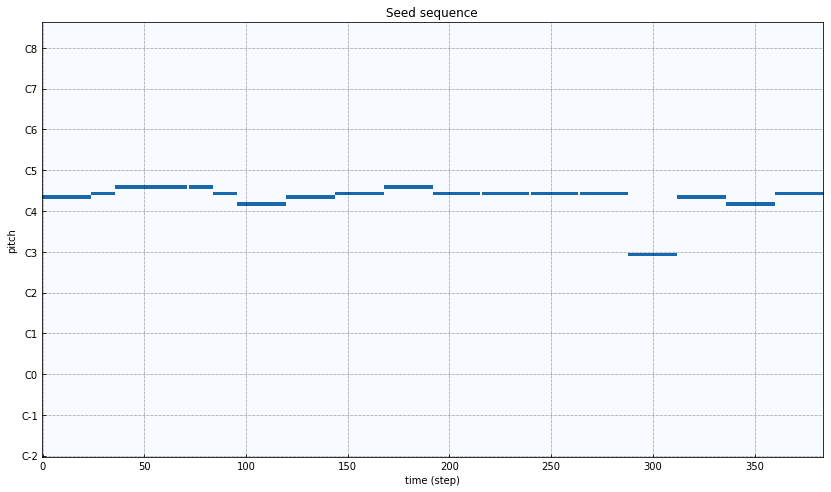

In [18]:
roll = pypianoroll.Multitrack(seedpath).tracks[0]

plt.figure(figsize=(14,8))
ax = plt.gca()
pypianoroll.plot_pianoroll(ax, roll.pianoroll)
plt.title("Seed sequence")
plt.show()

  0%|                                                             | 0/10 [00:00<?, ?it/s]

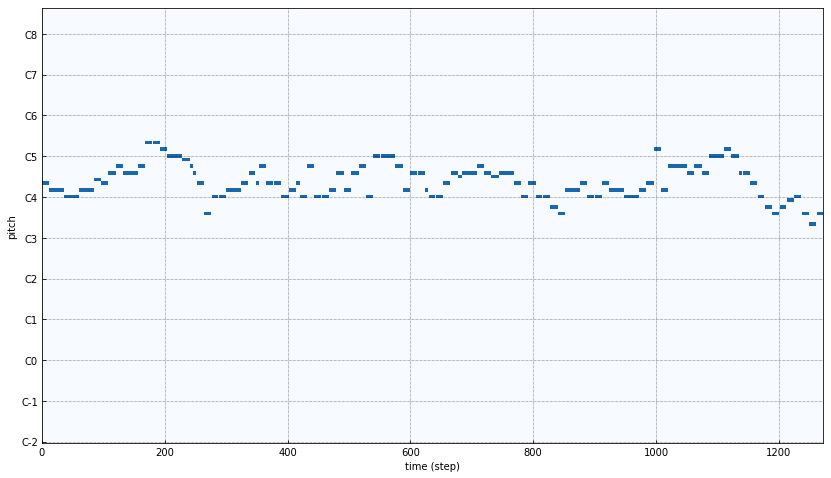

 10%|█████▎                                               | 1/10 [00:08<01:13,  8.13s/it]

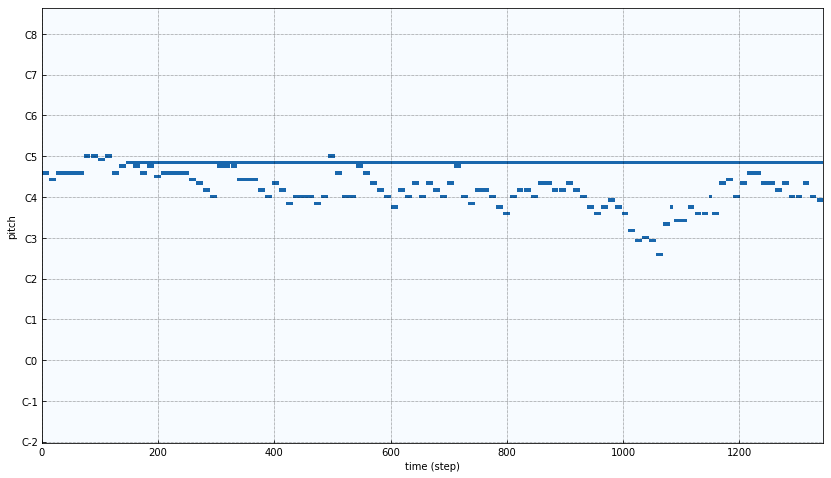

 20%|██████████▌                                          | 2/10 [00:16<01:05,  8.23s/it]

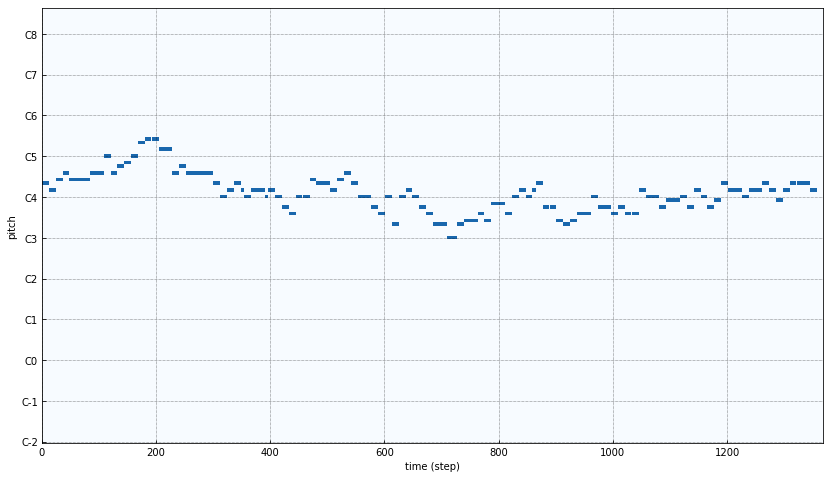

 30%|███████████████▉                                     | 3/10 [00:25<00:58,  8.31s/it]

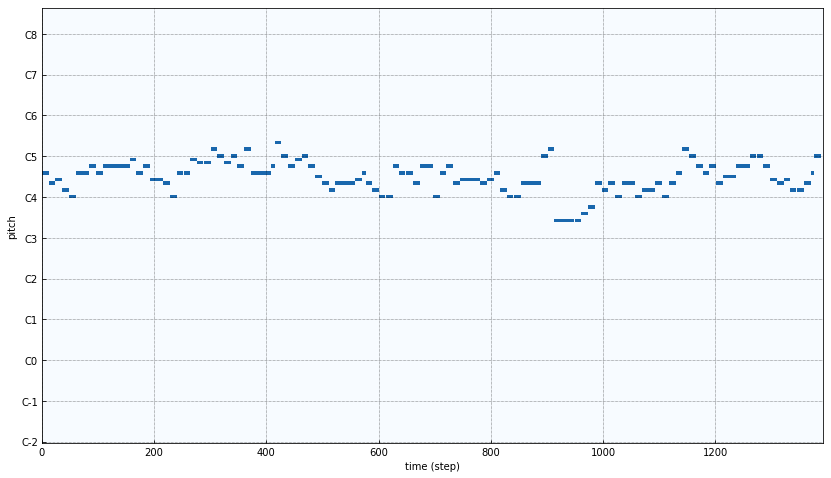

 40%|█████████████████████▏                               | 4/10 [00:33<00:49,  8.27s/it]

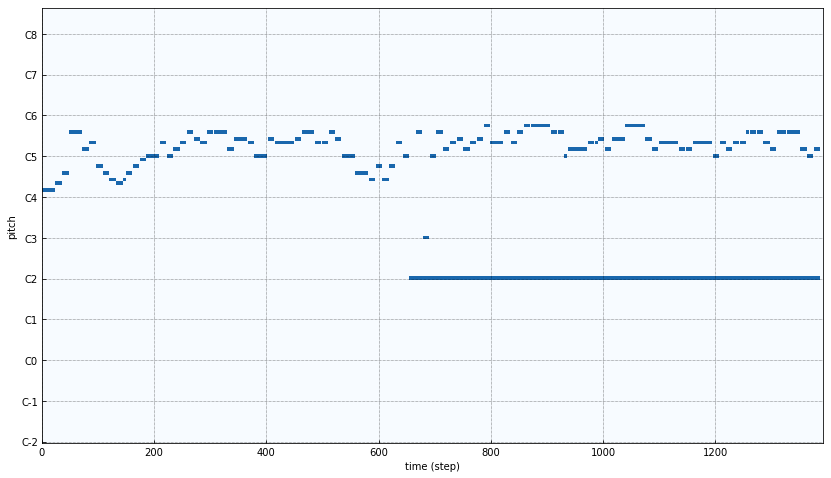

 50%|██████████████████████████▌                          | 5/10 [00:41<00:40,  8.17s/it]

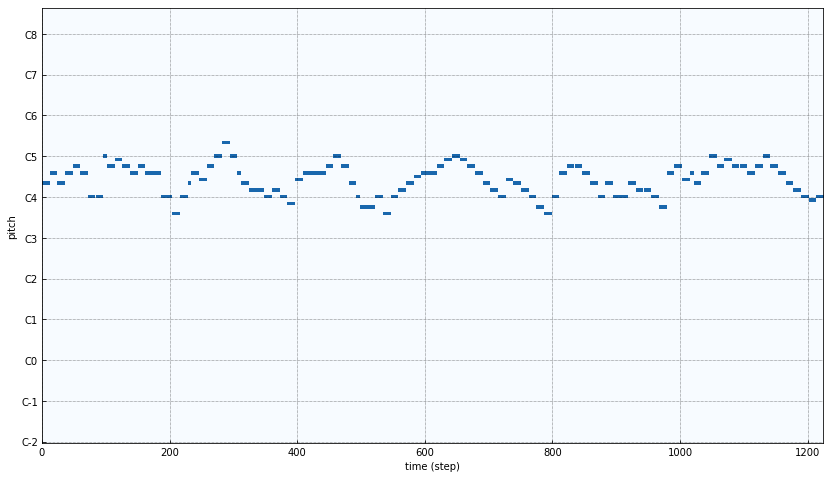

 60%|███████████████████████████████▊                     | 6/10 [00:49<00:32,  8.11s/it]

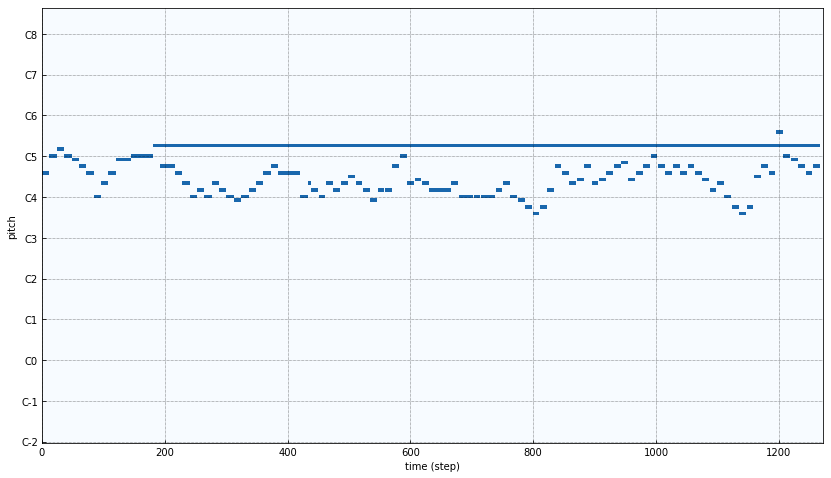

 70%|█████████████████████████████████████                | 7/10 [00:57<00:24,  8.07s/it]

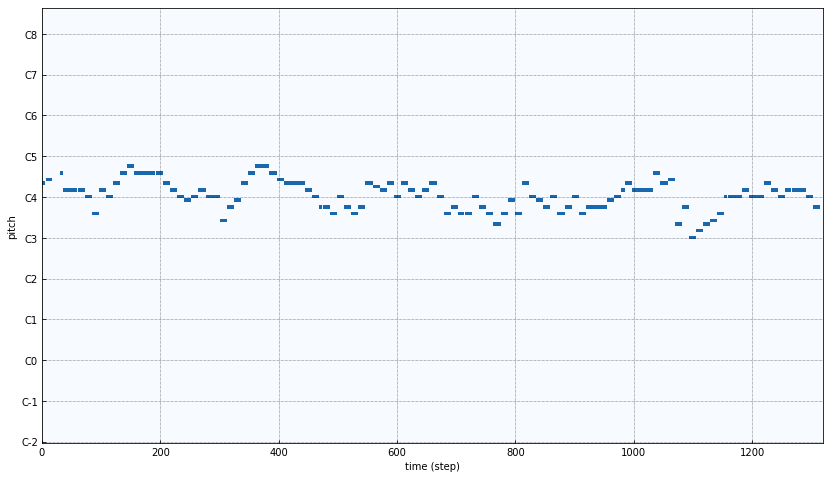

 80%|██████████████████████████████████████████▍          | 8/10 [01:05<00:16,  8.03s/it]

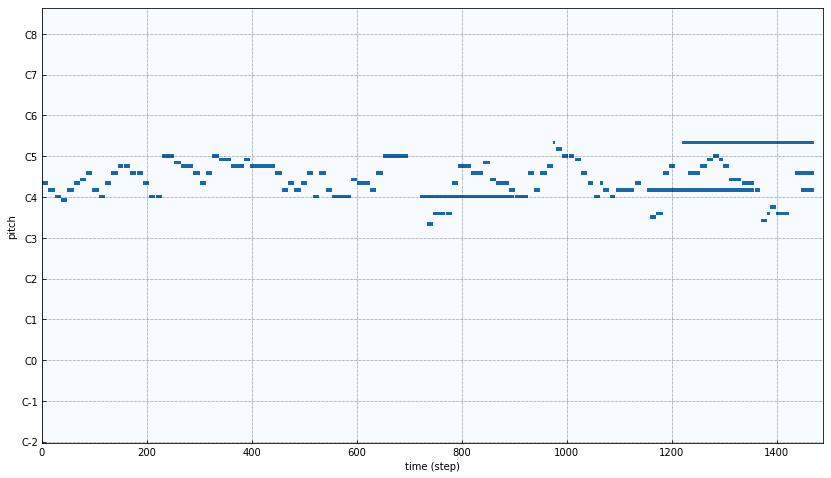

 90%|███████████████████████████████████████████████▋     | 9/10 [01:13<00:08,  8.05s/it]

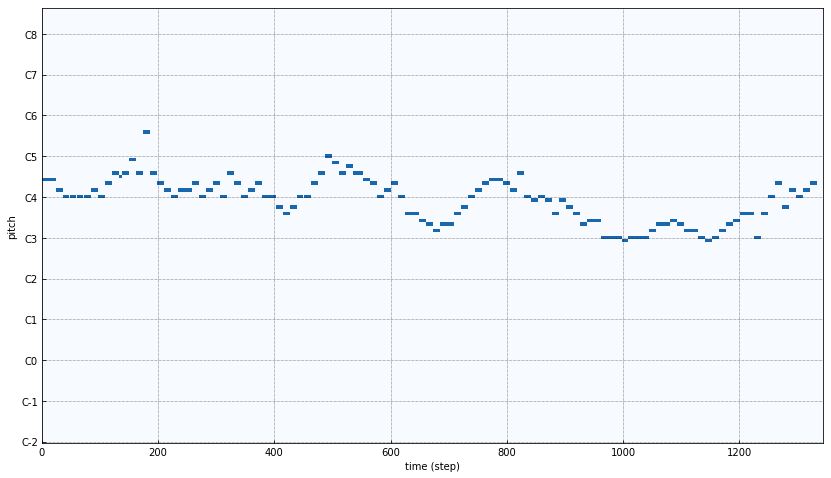

100%|████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.05s/it]


In [19]:
temperature = 1.0

nr_samples = 10

for i in tqdm(list(range(nr_samples))):
    
    for timestep in range(INPUT_SEQ_LEN, len(generated)):
        start_index = timestep - (INPUT_SEQ_LEN)
        sequence_for_prediction = generated[start_index:timestep]
        next_step = sample(model, sequence_for_prediction, temperature)
#         print('step %s: %s' %(timestep, my_encoder.printevents(np.argmax(next_step,axis=1))))
        generated[timestep] = next_step

    new_path = os.path.join(samples_dir, "temp_%s_%s.mid" %(temperature, i))
    my_encoder.encoder.decode(remove_zeros_from_onehot(generated[INPUT_SEQ_LEN:]), path=new_path)
#     mono_melody = melodies_lib.midi_file_to_melody(new_path)
#     midi_io.note_sequence_to_midi_file(mono_melody.to_sequence(), new_path)
    
#     if nr_samples - i < 4:
    roll = pypianoroll.Multitrack(new_path).tracks[0]

    plt.figure(figsize=(14,8))
    ax = plt.gca()
    pypianoroll.plot_pianoroll(ax, roll.pianoroll)
    plt.show()